In [2]:
#Import dependencies
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import scipy.stats as stats
from scipy.stats import linregress

In [3]:
df = pd.read_csv("census_and_epa.csv")
df['PercentGoodDays'] = 100 * df['Good Days']/df['Days with AQI']

In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'State', 'County', 'Year',
       'Days with AQI', 'Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10', 'CountyState Name',
       'Total Population', 'Total Under 18', 'Total 18 to 64',
       'Total 65 and over', 'Total Male', 'Total Female', 'Total 16 and Over',
       'Total 16 and Over Employed', 'InPoverty Population',
       'InPoverty Under 18', 'InPoverty 18 to 64', 'InPoverty 65 and Over',
       'InPoverty Male', 'InPoverty Female', 'InPoverty 16 and Over',
       'InPoverty 16 and Over Employed', 'PctBelowPoverty Population',
       'PctBelowPoverty Under 18', 'PctBelowPoverty 18 to 64',
       'PctBelowPoverty 65 and over', 'PctBelowPoverty Male',
       'PctBelowPoverty Female', 'PctBelowPoverty 16 and Over',
   

In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import rankdata
from scipy.stats import kendalltau

def compute_correlations_by_year(df):
    years = df.Year.unique()
    
    for year in years:
        df_year = df[df.Year == year]
        df_clean = df_year[['PercentGoodDays', 'PctBelowPoverty Population']].dropna()
        n = df_clean.shape[0]
        rval, pval = pearsonr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
        print(f"Year: {year}, nobs: {n}, Pearson's r: {rval:.2f}, p-value: {pval:.2f}")
        rval, pval = spearmanr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
        print(f"Year: {year}, nobs: {n}, Spearman's r: {rval:.2f}, p-value: {pval:.2f}")
        x = rankdata(df_clean['PercentGoodDays'])
        y = rankdata(df_clean['PctBelowPoverty Population'])
        rval, pval = kendalltau(x, y)
        print(f"Year: {year}, nobs: {n}, Kendall's tau: {rval:.2f}, p-value: {pval:.2f}")

compute_correlations_by_year(df)

Year: 2012, nobs: 613, Pearson's r: -0.05, p-value: 0.18
Year: 2012, nobs: 613, Spearman's r: -0.05, p-value: 0.24
Year: 2012, nobs: 613, Kendall's tau: -0.03, p-value: 0.25
Year: 2013, nobs: 608, Pearson's r: -0.08, p-value: 0.05
Year: 2013, nobs: 608, Spearman's r: -0.05, p-value: 0.23
Year: 2013, nobs: 608, Kendall's tau: -0.03, p-value: 0.22
Year: 2014, nobs: 607, Pearson's r: -0.12, p-value: 0.00
Year: 2014, nobs: 607, Spearman's r: -0.08, p-value: 0.04
Year: 2014, nobs: 607, Kendall's tau: -0.06, p-value: 0.04
Year: 2015, nobs: 611, Pearson's r: -0.09, p-value: 0.03
Year: 2015, nobs: 611, Spearman's r: -0.07, p-value: 0.09
Year: 2015, nobs: 611, Kendall's tau: -0.05, p-value: 0.09
Year: 2016, nobs: 609, Pearson's r: -0.06, p-value: 0.13
Year: 2016, nobs: 609, Spearman's r: -0.03, p-value: 0.45
Year: 2016, nobs: 609, Kendall's tau: -0.02, p-value: 0.45
Year: 2017, nobs: 611, Pearson's r: -0.08, p-value: 0.06
Year: 2017, nobs: 611, Spearman's r: -0.10, p-value: 0.02
Year: 2017, nob

In [27]:
# With all years combined we see a significant, small, negative association between
# PercentGoodDays and PctBelowPoverty Population

def compute_all_years_correlations(df):
    df_clean = df[['PercentGoodDays', 'PctBelowPoverty Population']].dropna()
    n = df_clean.shape[0]
    rval, pval = pearsonr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
    print(f"nobs: {n}, Pearson's r: {rval:.2f}, p-value: {pval:.2f}")
    rval, pval = spearmanr(df_clean['PercentGoodDays'], df_clean['PctBelowPoverty Population'])
    print(f"nobs: {n}, Spearman's r: {rval:.2f}, p-value: {pval:.2f}")
    x = rankdata(df_clean['PercentGoodDays'])
    y = rankdata(df_clean['PctBelowPoverty Population'])
    rval, pval = kendalltau(x, y)
    print(f"nobs: {n}, Kendall's tau: {rval:.2f}, p-value: {pval:.2f}")

compute_all_years_correlations(df)

nobs: 3659, Pearson's r: -0.10, p-value: 0.00
nobs: 3659, Spearman's r: -0.08, p-value: 0.00
nobs: 3659, Kendall's tau: -0.06, p-value: 0.00


In [13]:

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy.builtins import *

# Fit a quadratic model for all years

model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     45.21
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           4.03e-20
Time:                                     17:26:28   Log-Likelihood:                -11623.
No. Observations:                             3659   AIC:                         2.325e+04
Df Residuals:                                 3656   BIC:                         2.327e+04
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

C:\Users\dadra\anaconda\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


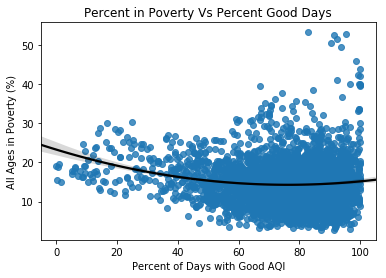

In [14]:
import seaborn

def plot_all_years_seaborn (df):
    
    ax2 = seaborn.regplot(df['PercentGoodDays'], df['PctBelowPoverty Population'],\
                          order=2,\
                         line_kws={"color":"black"})

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days")
    
plot_all_years_seaborn(df)

In [15]:
# What points are in the upper right hand corner of the plot?
# These points appear to differ from the remaining data
outliers_df = df[(df['PercentGoodDays'] >= 80) & (df['PctBelowPoverty Population'] >= 30)]

In [19]:
outliers_df.State.value_counts()

Puerto Rico       15
Arizona            6
North Carolina     2
New Mexico         2
Ohio               1
Georgia            1
South Carolina     1
Tennessee          1
Florida            1
Name: State, dtype: int64

In [20]:
outliers_df.County.value_counts()

Apache        6
Ponce         6
San Juan      6
McKinley      2
Robeson       2
Caguas        2
Putnam        2
Bayamon       1
Darlington    1
Clarke        1
Athens        1
Name: County, dtype: int64

In [21]:
# Arizona Apache - reservation
# New Mexico McKinley - reservation
outliers_df[['State', 'County']]

,State,County
13,Arizona,Apache
336,New Mexico,McKinley
387,North Carolina,Robeson
479,Puerto Rico,Ponce
480,Puerto Rico,San Juan
626,Arizona,Apache
947,New Mexico,McKinley
1086,Puerto Rico,Ponce
1087,Puerto Rico,San Juan
1095,South Carolina,Darlington


                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.035
Model:                                         OLS   Adj. R-squared:                  0.032
Method:                              Least Squares   F-statistic:                     11.20
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           1.67e-05
Time:                                     17:45:57   Log-Likelihood:                -1951.0
No. Observations:                              613   AIC:                             3908.
Df Residuals:                                  610   BIC:                             3921.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

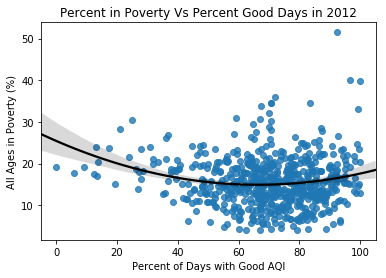

In [31]:

def fit_model_by_year (df, year):
    df_year = df[df.Year == year]
    
    ax2 = seaborn.regplot(df_year['PercentGoodDays'], df_year['PctBelowPoverty Population'],\
                          order = 2, line_kws={"color":"black"})

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days in {year}")
    
    model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df_year).fit()
    print(model.summary())

fit_model_by_year(df, 2012)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.034
Model:                                         OLS   Adj. R-squared:                  0.031
Method:                              Least Squares   F-statistic:                     10.76
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           2.56e-05
Time:                                     17:46:12   Log-Likelihood:                -1942.4
No. Observations:                              608   AIC:                             3891.
Df Residuals:                                  605   BIC:                             3904.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

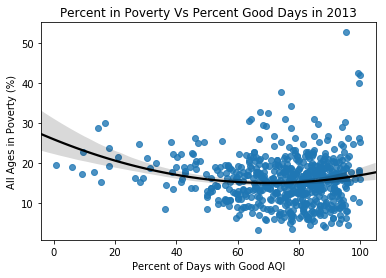

In [32]:
fit_model_by_year(df, 2013)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.027
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     8.462
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           0.000238
Time:                                     17:46:29   Log-Likelihood:                -1924.2
No. Observations:                              607   AIC:                             3854.
Df Residuals:                                  604   BIC:                             3868.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

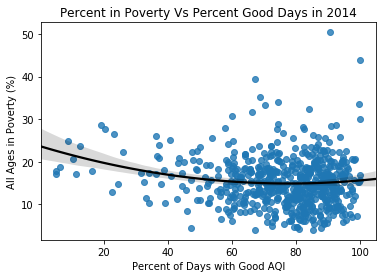

In [33]:
fit_model_by_year(df, 2014)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.027
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     8.515
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           0.000225
Time:                                     17:46:52   Log-Likelihood:                -1933.6
No. Observations:                              611   AIC:                             3873.
Df Residuals:                                  608   BIC:                             3886.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

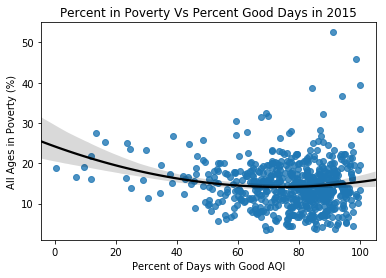

In [34]:
fit_model_by_year(df, 2015)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.016
Model:                                         OLS   Adj. R-squared:                  0.013
Method:                              Least Squares   F-statistic:                     5.062
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):            0.00660
Time:                                     17:47:04   Log-Likelihood:                -1910.6
No. Observations:                              609   AIC:                             3827.
Df Residuals:                                  606   BIC:                             3840.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

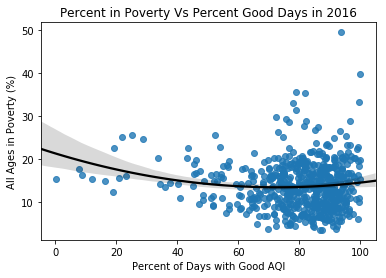

In [35]:
fit_model_by_year(df, 2016)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.016
Model:                                         OLS   Adj. R-squared:                  0.013
Method:                              Least Squares   F-statistic:                     5.062
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):            0.00660
Time:                                     17:47:10   Log-Likelihood:                -1910.6
No. Observations:                              609   AIC:                             3827.
Df Residuals:                                  606   BIC:                             3840.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

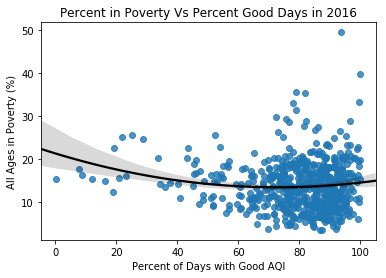

In [36]:
fit_model_by_year(df, 2016)

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.010
Model:                                         OLS   Adj. R-squared:                  0.007
Method:                              Least Squares   F-statistic:                     3.024
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):             0.0493
Time:                                     17:47:39   Log-Likelihood:                -1912.1
No. Observations:                              611   AIC:                             3830.
Df Residuals:                                  608   BIC:                             3843.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

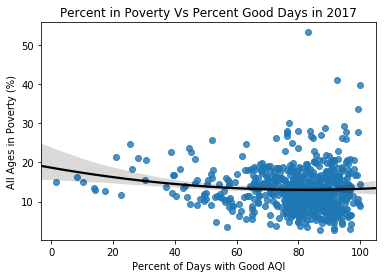

In [37]:
fit_model_by_year(df, 2017)

In [42]:
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2) + Q("Total Population") + C(Year)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.052
Model:                                         OLS   Adj. R-squared:                  0.050
Method:                              Least Squares   F-statistic:                     24.99
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           7.93e-38
Time:                                     17:59:38   Log-Likelihood:                -11570.
No. Observations:                             3659   AIC:                         2.316e+04
Df Residuals:                                 3650   BIC:                         2.321e+04
Df Model:                                        8                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['PopnScaled'] = scaler.fit_transform(df['Total Population'].values.reshape(-1,1))

C:\Users\dadra\anaconda\Anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
model = smf.ols(formula = 'Q("PctBelowPoverty Population") ~ PercentGoodDays + np.power(PercentGoodDays, 2) + PopnScaled + C(Year)', data = df).fit()
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("PctBelowPoverty Population")   R-squared:                       0.052
Model:                                         OLS   Adj. R-squared:                  0.050
Method:                              Least Squares   F-statistic:                     24.99
Date:                             Fri, 12 Apr 2019   Prob (F-statistic):           7.93e-38
Time:                                     18:12:52   Log-Likelihood:                -11570.
No. Observations:                             3659   AIC:                         2.316e+04
Df Residuals:                                 3650   BIC:                         2.321e+04
Df Model:                                        8                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

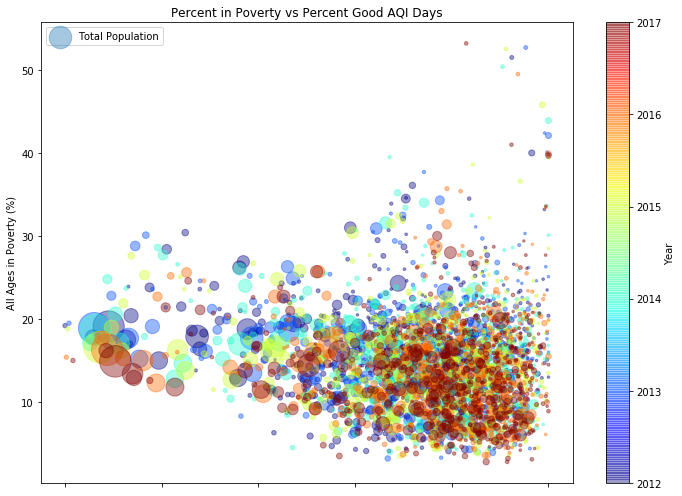

In [60]:
ax = df.plot(kind="scatter", x="PercentGoodDays", y="PctBelowPoverty Population", alpha=0.4,\
       s=df['Total Population']/10000, label="Total Population", figsize=(10,7),\
       c="Year", cmap=plt.get_cmap("jet"), colorbar=True)
#plt.legend()
ax.set_xlabel("Percent of Good AQI Days")
ax.set_ylabel("All Ages in Poverty (%)")
ax.set_title("Percent in Poverty vs Percent Good AQI Days")
plt.legend()
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023452CA2780>,
      dtype=object)

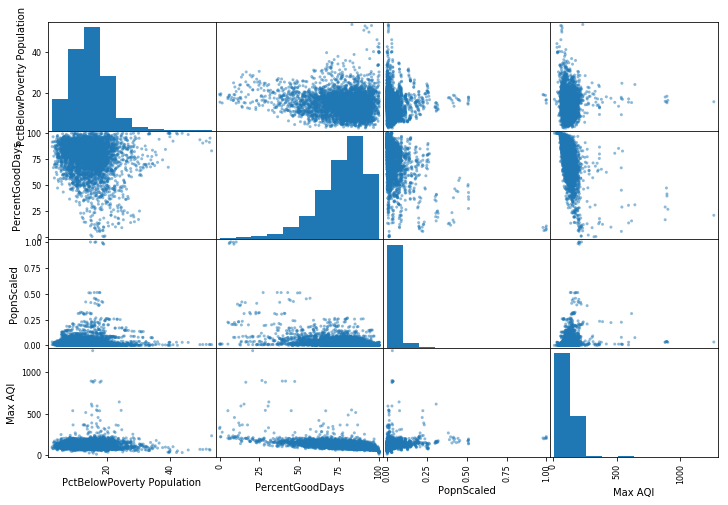

In [65]:
from pandas.plotting import scatter_matrix

attributes = ['PctBelowPoverty Population', 'PercentGoodDays', 'PopnScaled', 'Max AQI']
scatter_matrix(df[attributes], figsize=(12,8))